<a href="https://colab.research.google.com/github/yakkunn7422/public_colab/blob/main/ai_contest_thema2_re20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Signateから 学習・評価用のデータ一式をダウンロード

# 1. SIGNATE(https://signate.jp/) でアカウント登録
# 初めてアクセスする際は、「コンペティションへの同意」を聞かれるので y 入力 必要

!pip install signate
!signate token --email=yakkunn7422@gmail.com --password=signate
#!signate list
!signate files --competition-id=270
!signate download --competition-id=270 --path=/content/sample_data/

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=adf4648d9f03cdbd2218ab9980d5207cd67f8abc519d4152f756743b84b6cd06
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
The API Token has been downloaded successfully.
  fileId  name                   title                         size  updated_at
--------  ---------------------  ----------------------  ----------  -------------------
     757  sat_image_2018.zip     衛星画像2018年          1196800853  2019-09-10 02:36:11
     755  sat_image_2017_01.zip  衛星画像2017年前半      1100993010  2019-09-10 02:36:11
     756  sat_image_2017_02.zip  衛星画像2017年後半      1109747198  2019-09-10 02:36:11
     762  sat_image_2016_01.zip  衛星画像2016年前半      1111602835  2019-09-10 02:36:11
     763  sat_image_2016_02.zip  衛星画像2016年後半      1119587373  2019-09-10 02:36:11
     753  met_data_2018_01.zip   気象データ2018年前半    1109284

In [3]:
# zipファイルをすべて解凍する。

import os
import zipfile
import shutil

source_folder = '/content/sample_data/'
destination_folder = '/content/sample_data/'

# 衛星画像、気象データ対象ファイルのリスト（ファイル名だけ）
zip_files = ['sat_image_2017_01.zip', 'sat_image_2017_02.zip', 'sat_image_2016_01.zip','sat_image_2016_02.zip',
             'met_data_2017_01.zip','met_data_2017_02.zip','met_data_2016_01.zip','met_data_2016_02.zip','add_met_data_2016.zip',
             'sat_image_2018.zip','met_data_2018_01.zip','met_data_2018_02.zip'
             ]

# zipファイルを解凍する関数
def unzip_files(file_list, source_dir, extract_to):
    os.makedirs(extract_to, exist_ok=True)  # 解凍先フォルダがなければ作る

    for file_name in file_list:
        zip_path = os.path.join(source_dir, file_name)  # YYYとファイル名を結合
        if os.path.exists(zip_path) and zipfile.is_zipfile(zip_path):
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
                print(f"解凍しました: {zip_path} → {extract_to}")
        else:
            print(f"ファイルが存在しないか、zipファイルではありません: {zip_path}")

# 衛星画像、気象データ対象ファイル を解凍
unzip_files(zip_files, source_folder, destination_folder)

shutil.copy2("/content/sample_data/data/HGT.300.3.2016010718.gz", "/content/sample_data/train/met/2016/01/07/")
shutil.copy2("/content/sample_data/data/RH.1p5m.3.2016011218.gz", "/content/sample_data/train/met/2016/01/12/")
shutil.copy2("/content/sample_data/data/TMP.850.3.2016011209.gz", "/content/sample_data/train/met/2016/01/12/")


解凍しました: /content/sample_data/sat_image_2017_01.zip → /content/sample_data/
解凍しました: /content/sample_data/sat_image_2017_02.zip → /content/sample_data/
解凍しました: /content/sample_data/sat_image_2016_01.zip → /content/sample_data/
解凍しました: /content/sample_data/sat_image_2016_02.zip → /content/sample_data/
解凍しました: /content/sample_data/met_data_2017_01.zip → /content/sample_data/
解凍しました: /content/sample_data/met_data_2017_02.zip → /content/sample_data/
解凍しました: /content/sample_data/met_data_2016_01.zip → /content/sample_data/
解凍しました: /content/sample_data/met_data_2016_02.zip → /content/sample_data/
解凍しました: /content/sample_data/add_met_data_2016.zip → /content/sample_data/
解凍しました: /content/sample_data/sat_image_2018.zip → /content/sample_data/
解凍しました: /content/sample_data/met_data_2018_01.zip → /content/sample_data/
解凍しました: /content/sample_data/met_data_2018_02.zip → /content/sample_data/


'/content/sample_data/train/met/2016/01/12/TMP.850.3.2016011209.gz'

In [ ]:
!ls -lrta /content/sample_data/train/met/2016/01/01

In [6]:
# モデリング (train) / 評価 (test)

# 改善案)
# ・正規化の時にfloat64で正規化
# ・クロスバリデーション実施

# ライブラリのインポート
import os
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D,TimeDistributed
from tensorflow.keras.layers import Conv2D,Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

source_folder = '/content/drive/MyDrive/2024_AIContest2/Thema2/'

mode = 'train' # 学習時は「train」表示は「test」

train_sat_name = os.path.join(source_folder, 'train_sat.npy')
test_sat_name  = os.path.join(source_folder, 'test_sat.npy')

best_h5        = 'my_model_Epoch132_loss0.0818_valloss0.0838.weights.h5'
best_h5_name   = os.path.join(source_folder, best_h5)

### モデルの作成 ###
# モデルを初期化する
model = Sequential()

# Encoder 追加
# 改善POINT filters、kernel_size
model.add(ConvLSTM2D(
  filters=20, kernel_size=(3, 3),
  padding='same', return_sequences=False,
  activation='tanh', recurrent_activation='sigmoid',
  input_shape=(24, 33, 25, 1)))

# EncoderとDecoderをつなぐ中間部分 追加
def repeat_last_status(x):
    x = tf.reshape(x, (-1, 1, 33, 25, 20))
    copied_x = tf.identity(x)
    for _ in range(23):
        x = tf.concat([x, copied_x], axis=1)
    return x
model.add(Lambda(repeat_last_status))

# Decoder 追加
model.add(ConvLSTM2D(
  filters=20, kernel_size=(3, 3),
  padding='same', return_sequences=True,
  activation='tanh', recurrent_activation='sigmoid'))

# 出力層 追加
model.add(TimeDistributed(Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')))

# モデルをコンパイルする
model.compile(loss='mae', optimizer='adam')

if mode == 'train':
    ### データ前処理 ###
    # npyを読み込む

    train_sat_dataset = np.load(train_sat_name)

    # 学習用データ、検証用データを抽出する
    train_sat = train_sat_dataset[:365]
    val_sat   = train_sat_dataset[365:]

    # 衛星画像データを正規化する
    train_sat = train_sat.astype(np.float32) / 255
    val_sat   = val_sat.astype(np.float32) / 255

    # 入力データと正解データを作る → 次の1日分が正解データ
    X_index = np.arange(364)   # 0-363(364個) のIndex作成
    Y_index = np.arange(1,365) # 1-364(364個) のIndex作成

    X_train = train_sat[X_index]
    Y_train = train_sat[Y_index]
    X_val   = val_sat[X_index]
    Y_val   = val_sat[Y_index]

    ### モデルを使って学習実施 ###
    # 検証用データをタプルにまとめる
    validation_data = (X_val, Y_val)

    # EarlyStoppingの設定
    e_stopping = EarlyStopping(monitor='val_loss', patience=30)

    # Checkpointの設定
    checkpoint = ModelCheckpoint(filepath='my_model_Epoch{epoch}_loss{loss:.4f}_valloss{val_loss:.4f}.weights.h5',
                                monitor='val_loss', save_best_only=True, save_weights_only=True)

    # callbacksをリストにまとめる
    callbacks = [e_stopping, checkpoint]

    # 学習を実行する
    history = model.fit(x=X_train, y=Y_train, batch_size=16, epochs=200,
                    validation_data=validation_data, callbacks=callbacks)

    # 結果をグラフで出力
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

else:
    ### データ前処理 ###
    # npyを読み込む
    test_sat_dataset = np.load(test_sat_name)

    # 前処理 正規化
    X_test = test_sat_dataset.astype(np.float32) / 255

    model.load_weights(best_h5_name)
    Y_pred = model.predict(X_test)
    Y_pred = Y_pred * 255.0
    Y_pred = np.round(Y_pred)

    np.save('predicted_satellite.npy', Y_pred)

    # 評価結果を出力
    # 出力サイズの定義
    resized_h, resized_w = 672, 512
    crop_y1, crop_y2     = 40, 460  # 縦方向 切り出し
    crop_x1, crop_x2     = 130, 470  # 横方向 切り出し
    target_hours         = [5, 11, 17, 23]  # 時刻インデックス

    # 各画像サイズ：420x340、200枚 → 全体サイズ：(420*200, 340)
    cropped_height = crop_y2 - crop_y1  # 420
    cropped_width  = crop_x2 - crop_x1  # 340
    total_images   = 50 * 4             # 200枚

    # 空の大きな配列（縦長）を作成
    vertical_concat_image = np.zeros((total_images * cropped_height, cropped_width), dtype=np.uint8)

    # 画像処理と縦方向への結合
    row_pos = 0
    for day in range(50):
        for hour in target_hours:
            img_small = Y_pred[day, hour, :, :, 0]  # (33, 25)
            img_resized = cv2.resize(img_small, (resized_w, resized_h), interpolation=cv2.INTER_LINEAR)
            cropped_img = img_resized[crop_y1:crop_y2, crop_x1:crop_x2]
            cropped_img_uint8 = np.clip(cropped_img, 0, 255).astype(np.uint8)

            vertical_concat_image[row_pos:row_pos + cropped_height, :] = cropped_img_uint8
            row_pos += cropped_height

    # DataFrameに変換（Index付き）
    df = pd.DataFrame(vertical_concat_image)
    df.index = np.arange(vertical_concat_image.shape[0])  # 0〜83999

    # CSVとして保存（行番号付き）
    df.to_csv('submit_image_with_index.csv', header=False, index=True)
    print('-- submit_image_with_index.csv Saved!')



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Final image shape: (84000, 340)
-- submit_image.csv Saved!


In [14]:
# 精度を上げるための施策
# ・24h(1日)ではなく、96hの画像をもとに分析する
# ・元の画像サイズを大きくする（初期は20分の1にResize）
# ・不足している画像データの補完方法を見直し（初期は存在する前の時間をCOPY）
# データセットの作成
# ★24h画像 → 24h画像 推測を行う場合は ★箇所を有効に。
#   学習用衛星画像データ　  train_sat.npy   (730,24,33,25,1)
#   テスト用衛星画像データ  test_sat.npy    (50,24,33,25,1)
#   学習用気象データ        train_met.npy   (730,24,33,25,34)
#   テスト用気象データ      test_met.npy    (50,24,33,25,34)

# ライブラリのインポート
import cv2
import gzip
from datetime import datetime as dt
from datetime import timedelta
import pandas as pd
import numpy as np

destination_folder = '/content/sample_data/'
source_folder = '/content/drive/MyDrive/2024_AIContest2/Thema2/'

file_name = 'inference_terms.csv'
csv_file_name = os.path.join(destination_folder, file_name)

met_data_type_list = ['HGT.200', 'HGT.300', 'HGT.500', 'HGT.700', 'HGT.850',
                     'PRMSL.msl',
                     'RH.1p5m', 'RH.300', 'RH.500', 'RH.700', 'RH.850',
                     'TMP.1p5m', 'TMP.200', 'TMP.300', 'TMP.500', 'TMP.700', 'TMP.850',
                     'UGRD.10m','UGRD.200', 'UGRD.300', 'UGRD.500', 'UGRD.700', 'UGRD.850',
                     'VGRD.10m', 'VGRD.200', 'VGRD.300', 'VGRD.500', 'VGRD.700', 'VGRD.850',
                     'VVEL.200', 'VVEL.300', 'VVEL.500', 'VVEL.700', 'VVEL.850']


# テスト対象期間の日付を取得する関数
#
def get_test_days_list():
    # test_terms.csvからtest対象期間の日付を取得
    test_terms = pd.read_csv(csv_file_name)

    # OpenData_startカラムのデータを日付型のデータとして取得する
    start_dates = pd.to_datetime(test_terms['OpenData_96hr_Start'])

    # ★ 過去24時間の画像から24時間分の画像を推測するとき用
    days_list = start_dates + pd.Timedelta(days=3)

    return days_list

# テスト対象期間の日付を取得
#print("--- get_test_days_list sample---")
#sample_test_days_list = get_test_days_list()
#print(sample_test_days_list[:5])

# 学習対象期間の日付を取得する関数
def get_train_days_list():

    start_date = dt(2016, 1, 1, 1)

    # 日付を格納するリストを初期化する
    days_list = []

    # 学習データは365日×２年分与えられるため、合計730日分の日時を取得する
    for i in range(2*365):

        # start_dateから、i日後の日時を取得し、dateに代入する
        date = start_date + timedelta(days=i)

        # days_listにdateを追加する
        days_list.append(date)

    return days_list

# 関数を実行して、学習データが提供されている日の日付を取得する
#print("--- get_train_days_list sample---")
#sample_train_days_list = get_train_days_list()
#print(sample_train_days_list[:5])

# dataの日付情報からフルパスのファイル名を返す
def create_file_name(date):

    # 日付(date)から、年(year)、月(month)、日(day)、時(hour)を数値データとして取得する
    year = date.year
    month = date.month
    day = date.day
    hour = date.hour

    # 2018年ならばテストデータ(test)
    if year == 2018:
        phase = 'test'
    # 2016年、2017年ならば学習データ(train)
    else:
        phase = 'train'

    # ファイル名を指定する
    file_name = f"{phase}/sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png"

    path_file_name = os.path.join(destination_folder, file_name)

    return path_file_name

def get_sat_data(date):

    # 衛星画像はファイルが存在しない時間(日)があるので、
    # ない場合は前の時間の画像を使う。
    file_exists = False
    while not file_exists:
        full_file_name = create_file_name(date)
        file_exists = os.path.exists(full_file_name)
        if not file_exists:
            date = date - timedelta(hours=1)
            print(f"Warning: File not found: {full_file_name}")
            print(f"Retry with date: {date}")

    # 画像の読み込み
    # 評価対象の Y軸 40-460グリッド X軸 128-472グリッド でトリミング
    # (評価対象は40-460、130-470だけど、metデータとサイズをあわせるために少し大きめ)
    sat_data = cv2.imread(full_file_name, 0)
    img_resize = sat_data[40:460, 128:472]

    return img_resize

# 「2016年1月1日16時」時点の衛星画像を読み込む
#print("--- get_sat_data sample---")
#sat_data = get_sat_data(dt(2016,1,1,1))
#print(sat_data.shape)
#print(sat_data)

# 気象データのgzを読み込んで配列で返す
def Read_gz_Binary(file_path):

    # 1. 変数file_tmpに「元のファイル名_tmp」となる文字列を代入
    file_tmp = file_path + "_tmp"

    # 2. gzipファイルを、「読み込み(r)モード & バイナリ(b)モード」 で開き、
    #     開いたファイルオブジェクトをf_inに代入する
    with gzip.open(file_path, 'rb') as f_in:

        # 3. ファイル名を「元のファイル名_tmp」としたファイルを
        #     open()関数の「書き込み(w)モード & バイナリ(b)モード」で新規作成し、
        #     ファイルオブジェクトをf_outとする
        with open(file_tmp, 'wb') as f_out:

            # 4. f_inのファイルオブジェクトをf_outにコピーする
            shutil.copyfileobj(f_in, f_out)

    # 5. バイナリファイルをNumPy配列として読み込む
    met_data = np.fromfile(file_tmp, np.float32)

    # 6. 一時的に作成した展開済みのバイナリファイル「元のファイル名_tmp」を削除する
    os.remove(file_tmp)

    # 7. 読み込んだ配列の形状を(168, 128)に整形する
    # 評価対象の Y軸 10-115グリッド X軸 32-118グリッド でトリミング
    # 画像とサイズはあわせる。
    met_data = met_data.reshape( [168,128] )
    met_resize = met_data[10:115, 32:118]
    return met_resize

# HGT.200.3.2016010100.gz の気象データを確認
#print("--- Read_gz_Binary sample---")
#tmp_file_name = '/content/sample_data/train/met/2016/01/01/HGT.200.3.2016010100.gz'
#tmp_array = Read_gz_Binary(tmp_file_name)
#print(tmp_array.shape)
#print(tmp_array)

## 気象データの欠損部分を補完する。
def fill_lack_data(data):

    '''
    # 評価データのトリミングを実施したため、欠損部分の補完は不要
    #
    ## 1. 北側、南側の未計測部分を補間する(上下)
    # 北側の未計測部分を補間する
    data[0:2] = data[2]
    # 南側の未計測部分を補間する
    data[154:] = data[153]

    ## 2. 西側の未計測部分を補間する(左右)

    # 西側の未計測部分を補間する
    data[:, :8] = data[:,8].reshape(-1, 1)
    '''

    return data

# 気象データを読み込むライブラリ
def get_met_data(date, data_type):

    # 日付(date)から、年(year)、月(month)、日(day)、時(hour)を数値データとして取得する
    year = date.year
    month = date.month
    day = date.day
    hour = date.hour

    # 2018年ならばテストデータ(test)
    if year == 2018:
        phase = 'test'
    # 2016年、2017年ならば学習データ(train)
    else:
        phase = 'train'

    # ファイル名を指定する
    file_name = f'{phase}/met/{year}/{month:02}/{day:02}/{data_type}.3.{year}{month:02}{day:02}{hour:02}.gz'

    full_file_name = os.path.join(destination_folder, file_name)

    # データの読み込み(Read_gz_Binary) -> 空白箇所の穴埋め(fill_lack_data)の順番で処理を行う
    met_data = fill_lack_data(Read_gz_Binary(full_file_name))

    return met_data

# 衛星画像のデータセットを作成
def make_sat_dataset(resize, phase):

    # 引数phaseの値に従って、
    # 学習用、もしくはテスト用のデータが与えられている日付を取得する
    ## [get_train_days_list()、get_test_days_list()はともにタスク1で作成した関数]
    if phase == 'train':
        start_date_list = get_train_days_list()
    elif phase == 'test':
        start_date_list = get_test_days_list()

    # データセットを格納するリストの初期化
    dataset = []

    # start_date_listから、順番にデータが与えられている日付を取得し、
    # 変数start_dateに代入する
    for start_date in start_date_list:

        # 一日分の衛星画像データを格納するリストの初期化
        data_in_1day = []

        # 24時間分の衛星画像を順番に取得する
        for i in range(24):
            # start_dateから、時間を「i時間」分進める
            date = start_date + timedelta(hours=i)

            # 与えられた日時(date)における衛星画像データを読み込む
            ## [get_sat_data()関数は当タスク内で作成した関数]
            sat_data = get_sat_data(date)

            # 引数resizeの値に従って、データを縮小する
            resized_data = cv2.resize(sat_data, ( int(512 / resize), int(672 / resize) ),
                                                          interpolation=cv2.INTER_AREA)

            # data_in_1dayリストへの値の追加
            data_in_1day.append(resized_data)

        # 1日分(24時間分)のデータを格納したリストをNumPy配列に変換する
        # 形状は(24, 高さ, 幅, 1)
        data_in_1day = np.array(data_in_1day, dtype='uint8').reshape(24, int(672 / resize), int(512 / resize), 1)

        # 取得した1日分のNumPy配列をdatasetリストに追加する
        dataset.append(data_in_1day)

    # 対象期間に含まれる全データを格納したリストをNumPy配列に変換する
    # 形状は(対象期間の日数, 24, 高さ, 幅, 1)
    dataset = np.array(dataset, dtype='uint8').reshape(len(start_date_list), 24, int(672 / resize), int(512 / resize), 1)

    # 保存するnpyファイル名を指定する
    save_name = f'{phase}_sat_re20.npy'

    full_save_name = os.path.join(source_folder, save_name)

    # NumPy配列をnpyファイルとして保存する
    np.save(full_save_name, dataset)

# 気象データのデータセットを作成
def make_met_dataset(resize, phase, data_type_list):

    if phase == 'train':
        start_date_list = get_train_days_list()
    elif phase == 'test':
        start_date_list = get_test_days_list()

    # 全種類、全日時分のデータを格納するリストの初期化
    dataset = []

    for start_date in start_date_list:

        print(start_date)
        # 引数data_type_listから、
        # 気象データの種類を示す文字列を1つずつ取り出す。
        for count, data_type in enumerate(data_type_list):

            # 1種類、1日分のデータを格納するリストの初期化
            one_type_in_1day = []

            for i in range(24):

                date = start_date + timedelta(hours=i)
                hour = date.hour

                """データ補間処理の方針
                A:
                3で割り切ることのできる時刻T(0時, 3時, 6時, 9時, 12時, 15時, 18時, 21時)は、
                気象データが提供されているため、単純にデータを読み込む。

                B:
                それ以外の時刻T+1とT+2については、
                時刻Tと時刻T+3時点の気象データを利用して、値を補間する。

                """

                # 時刻がT[0, 3, 6, 9, 12, 15, 18, 21]時の場合
                if hour % 3 == 0:

                    met_data = get_met_data(date, data_type)

                # 時刻がT+1[1, 4, 7, 10, 13, 16, 19, 22]時の場合
                elif hour % 3 == 1:

                    # １時間前(時刻T)の気象データを読み込む
                    before_1h = date - timedelta(hours=1)
                    data_before_1h = get_met_data(before_1h, data_type)

                    # ２時間後(時刻T+3)の気象データを読み込む
                    after_2h = date + timedelta(hours=2)
                    data_after_2h = get_met_data(after_2h, data_type)

                    # 前後の値を利用して、補間する
                    met_data = (2/3) * data_before_1h + (1/3) * data_after_2h

                # 時刻がT+2[2, 5, 8, 11, 14, 17, 20, 23]時の場合
                else:

                    # ２時間前(時刻T)の気象データを読み込む
                    before_2h = date - timedelta(hours=2)
                    data_before_2h = get_met_data(before_2h, data_type)

                    # １時間後(時刻T+3)の気象データを読み込む
                    after_1h = date + timedelta(hours=1)
                    data_after_1h = get_met_data(after_1h, data_type)

                    # 前後の値を利用して、補間する
                    met_data = (1/3) * data_before_2h + (2/3) * data_after_1h

                # 引数resizeの値に従って、データを縮小する
                resized_data = cv2.resize(met_data, (int(512 / resize), int(672 / resize)),
                                                              interpolation=cv2.INTER_AREA)

                # 1種類、1時刻分のデータをone_type_in_1dayリストへ追加する
                one_type_in_1day.append(resized_data)

            one_type_in_1day = np.array(one_type_in_1day).reshape(24, int(672 / resize), int(512 / resize), 1)

            # 1種類目はall_type_in_1dayに代入する
            if count == 0:
                all_type_in_1day = one_type_in_1day
            # 2種類目以降はall_type_in_1dayにチャンネルの次元で結合する
            else:
                all_type_in_1day = np.concatenate([all_type_in_1day, one_type_in_1day], axis=3)

        # 全種類、1日分のデータをdatasetリストへ追加する
        dataset.append(all_type_in_1day)

    dataset = np.array(dataset, dtype='float32').reshape(len(start_date_list), 24, int(672 / resize), int(512 / resize), len(data_type_list))
    save_name = f'{phase}_met_re20.npy'
    full_save_name = os.path.join(source_folder, save_name)
    np.save(full_save_name, dataset)

#make_sat_dataset(resize=20, phase='train')
#make_sat_dataset(resize=20, phase='test')
make_met_dataset(resize=20, phase='train', data_type_list=met_data_type_list)
make_met_dataset(resize=20, phase='test', data_type_list=met_data_type_list)

2016-01-01 01:00:00
2016-01-02 01:00:00
2016-01-03 01:00:00
2016-01-04 01:00:00
2016-01-05 01:00:00
2016-01-06 01:00:00
2016-01-07 01:00:00
2016-01-08 01:00:00
2016-01-09 01:00:00
2016-01-10 01:00:00
2016-01-11 01:00:00
2016-01-12 01:00:00
2016-01-13 01:00:00
2016-01-14 01:00:00
2016-01-15 01:00:00
2016-01-16 01:00:00
2016-01-17 01:00:00
2016-01-18 01:00:00
2016-01-19 01:00:00
2016-01-20 01:00:00
2016-01-21 01:00:00
2016-01-22 01:00:00
2016-01-23 01:00:00
2016-01-24 01:00:00
2016-01-25 01:00:00
2016-01-26 01:00:00
2016-01-27 01:00:00
2016-01-28 01:00:00
2016-01-29 01:00:00
2016-01-30 01:00:00
2016-01-31 01:00:00
2016-02-01 01:00:00
2016-02-02 01:00:00
2016-02-03 01:00:00
2016-02-04 01:00:00
2016-02-05 01:00:00
2016-02-06 01:00:00
2016-02-07 01:00:00
2016-02-08 01:00:00
2016-02-09 01:00:00
2016-02-10 01:00:00
2016-02-11 01:00:00
2016-02-12 01:00:00
2016-02-13 01:00:00
2016-02-14 01:00:00
2016-02-15 01:00:00
2016-02-16 01:00:00
2016-02-17 01:00:00
2016-02-18 01:00:00
2016-02-19 01:00:00


In [ ]:

import cv2
from datetime import datetime as dt
from datetime import timedelta
import pandas as pd
import numpy as np

def test_sat_data(date):
    # 日付(date)から、年(year)、月(month)、日(day)、時(hour)を数値データとして取得する

    date = date - timedelta(days=1)

    year = date.year
    month = date.month
    day = date.day
    hour = date.hour

    print (year,month,day,hour)

test_sat_data(dt(2016,1,1,1))

2015 12 31 1


In [ ]:
import os
import zipfile

#ZIPファイルの解凍
sample_dir = "/content/sample_data"
os.chdir(sample_dir)
with zipfile.ZipFile('/content/drive/MyDrive/2024_AIContest2/Thema2/met_data_2018_01.zip') as myzip:
     myzip.extractall()

気象データに関する基本情報
<class 'numpy.ndarray'>
(168, 128)
最大値:  298.69208
最小値:  0.0
平均値:  238.8837
最大値:  298.69208
最小値:  243.35092
平均値:  282.1894


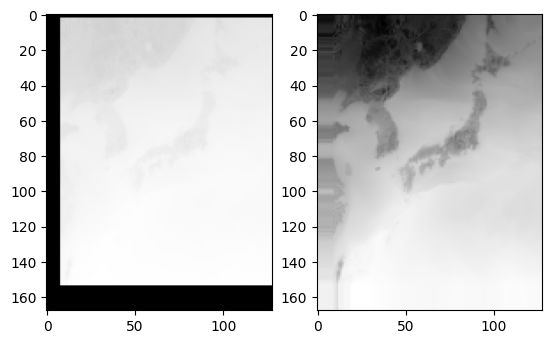

In [ ]:
# HGT: PMMSL:海面気温 RH:湿度 TMP:気温 UGRD:東西風 VGRD:南北風 VVEL:鉛直流

# ライブラリのインポート
import numpy as np
import gzip
import shutil
import matplotlib.pyplot as plt
# 気象データを読み込む関数; Read_gz_Binary を実装する
def Read_gz_Binary(file_path):
    file_tmp = file_path + "_tmp"
    with gzip.open(file_path, 'rb') as f_in:
        with open(file_tmp, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    # バイナリファイルをNumPy配列として読み込む
    met_data = np.fromfile(file_tmp, np.float32)
    os.remove(file_tmp)

    # 配列の次元に変更を加える
    met_data = met_data.reshape( [168,128] )

    return met_data

# 気象データのファイルパスを指定する
file_path = '/content/sample_data/train/met/2016/01/02/TMP.1p5m.3.2016010218.gz'

# 気象データを読み込む
met_data = Read_gz_Binary(file_path)

# 読み込んだ気象データに関する基本情報を出力する
print('気象データに関する基本情報')
print(type(met_data))
print(met_data.shape)

# 最大値の出力
print('最大値: ', np.max(met_data))
# 最小値の出力
print('最小値: ', np.min(met_data))
# 平均値の出力
print('平均値: ', np.mean(met_data))

#print(met_data)

plt.subplot(1, 2, 1)
plt.imshow(met_data, 'gray')

# fill_lack_data()関数を実装する
def fill_lack_data(data):
    ## 1. 北側、南側の未計測部分を補間する(上下)
    # 北側の未計測部分を補間する
    data[0:2] = data[2]
    # 南側の未計測部分を補間する
    data[154:] = data[153]
    ## 2. 西側の未計測部分を補間する(左右)
    # 西側の未計測部分を補間する
    data[:, :8] = data[:,8].reshape(-1, 1)

    return data

# fill_lack_data()関数をmet_dataに対して実行する
filled_data = fill_lack_data(met_data)

# 最大値の出力
print('最大値: ', np.max(met_data))
# 最小値の出力
print('最小値: ', np.min(met_data))
# 平均値の出力
print('平均値: ', np.mean(met_data))

plt.subplot(1, 2, 2)
plt.imshow(filled_data, 'gray')

plt.show()



In [ ]:
#指定したディレクトリ配下の画像を一覧表示させるコード
import os
from PIL import Image
import matplotlib.pyplot as plt
def display_images_from_directory(directory, images_per_row=5, max_display_count=20):
    # ファイルリストを取得
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    # 画像ファイルだけをフィルター
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))]
    # プロット設定
    num_images = min(len(image_files), max_display_count)
    plt.figure(figsize=(15, num_images // images_per_row * 3))

    for i, image_name in enumerate(image_files):
        if i >= max_display_count:
            break

        image_path = os.path.join(directory, image_name)

        with Image.open(image_path) as img:
            # 画像サイズを取得
            image_size = img.size
            image_size_kb = os.path.getsize(image_path) // 1024

        # プロット位置を設定
        ax = plt.subplot(num_images // images_per_row + 1, images_per_row, i + 1)

        # 画像を表示
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')

        # ファイル名とサイズを表示
        plt.title(f"{image_name}\n{image_size[0]}x{image_size[1]} px\n{image_size_kb} KB", fontsize=8)
    # レイアウト調整
    plt.tight_layout()
    plt.show()

# 使用例: ディレクトリパスを指定
directory_path = '/content/sample_data/test_images'

# 使用例: １列に3つずつ。最大20画像表示
display_images_from_directory(directory_path, images_per_row=3, max_display_count=20)

In [ ]:
import os
import shutil

source_folder = '/content/drive/MyDrive/2024_AIContest2/Thema2/'
destination_folder = '/content/sample_data/'
file_name = 'inference_terms.csv'

full_file_name = os.path.join(source_folder, file_name)

shutil.copy2(full_file_name, destination_folder)

'/content/sample_data/inference_terms.csv'

In [ ]:
#!for i in $(seq -w 1 31); do ls -1 /content/sample_data/train/met/2016/01/$i | wc -l; done
!find /content/sample_data/train/sat/2017-*-* -name "*.png"|wc -l

8733


データ形状: (365, 24, 33, 25, 1)


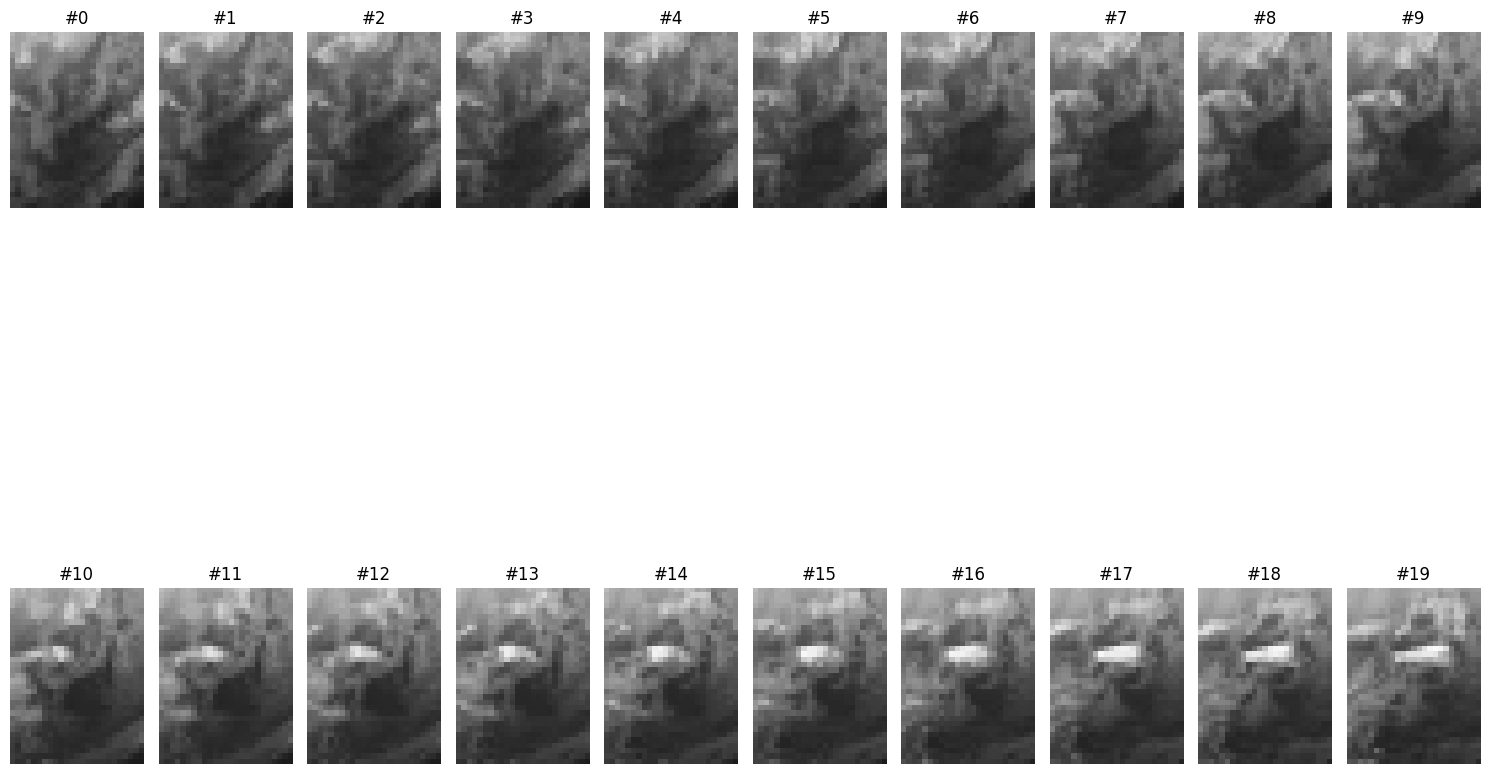

データ形状: (365, 24, 33, 25, 1)


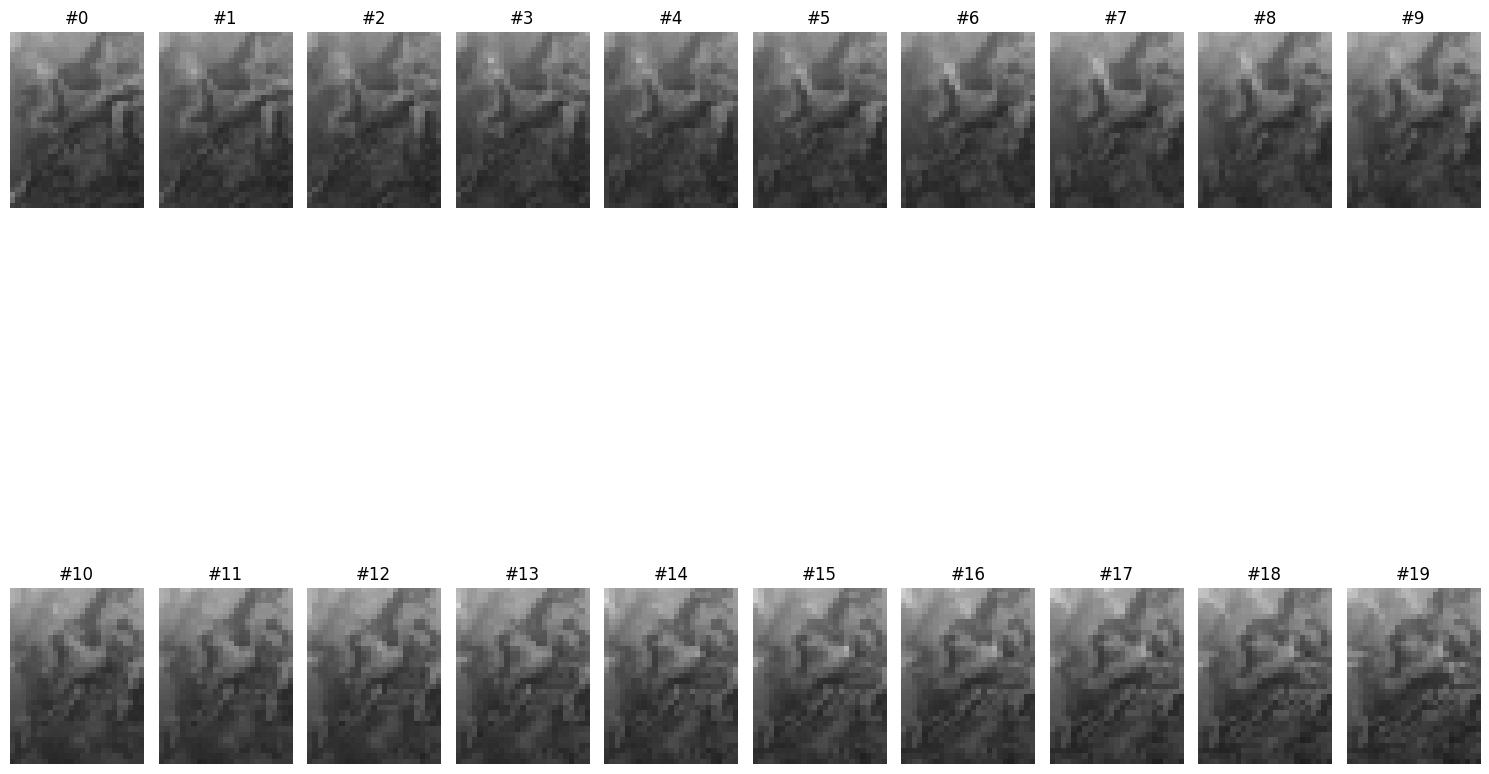

In [8]:
# npyファイルの画像を表示

# ライブラリのインポート
import os
import numpy as np
import matplotlib.pyplot as plt

source_folder = '/content/drive/MyDrive/2024_AIContest2/Thema2/'

# npyを読み込む
train_sat_name = os.path.join(source_folder, 'train_sat.npy')
train_sat_dataset = np.load(train_sat_name)

# 学習用データ、検証用データを抽出する
train_sat = train_sat_dataset[:365]
val_sat   = train_sat_dataset[365:]

# データの形状確認（例: (50, 24, 33, 25)）
print("データ形状:", train_sat.shape)

flattened = train_sat.reshape(-1, train_sat.shape[2], train_sat.shape[3])
images_to_show = flattened[:20]  # 最初の20枚

# --- 画像を2×10で並べて表示 ---
fig, axes = plt.subplots(2,10, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    ax.imshow(images_to_show[i], cmap='gray', vmin=0, vmax=255)
    ax.set_title(f"#{i}")
    ax.axis('off')  # 枠線・目盛りを非表示

plt.tight_layout()
plt.show()
